## SIMESH DEMO: INTRODUCTION AND MAIN FUNCS DISPLAY

### SIMESH Interfaces 


In [8]:
from simesh import amr_loader
import numpy as np

ds = amr_loader('data/tdm_ct.dat')

Load Clear


In [10]:
ds.header

{'datfile_version': 5,
 'offset_tree': 336,
 'offset_blocks': 8040,
 'nw': 8,
 'ndir': 3,
 'ndim': 3,
 'levmax': 3,
 'nleafs': 270,
 'nparents': 36,
 'it': 0,
 'time': 0.0,
 'xmin': array([-4., -6.,  0.]),
 'xmax': array([ 4.,  6., 12.]),
 'domain_nx': array([32, 48, 48]),
 'block_nx': array([16, 16, 16]),
 'periodic': array([False, False, False]),
 'geometry': 'Cartesian_3D',
 'staggered': False,
 'w_names': ['rho', 'm1', 'm2', 'm3', 'e', 'b1', 'b2', 'b3'],
 'physics_type': 'mhd',
 'n_par': 1,
 'params': array([1.66666667]),
 'param_names': ['gamma'],
 'snapshotnext': 1,
 'slicenext': 0,
 'collapsenext': 0}

In [9]:
ds.tree

(array([2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        1, 1, 1, 1, 1, 1]),
 array([[ 1,  1,  1],
        [ 3,  1,  1],
        [ 4,  1,  1],
        [ 3,  2,  

In [9]:
# sfc_to_node is a list of OctreeNodePointer, each pointer points to a leaf node
# The sequence of sfc_to_node is the sequence of leaf nodes in the Morton order
ds.mesh.forest.sfc_to_node[0].node

OctreeNode(ig=(0,0,0), level=2, morton=1, leaf=True)

In [15]:
# rnode is the node attribute of the leaf node
# xmin, ymin, zmin, xmax, ymax, zmax, dx, dy, dz for each element
ds.mesh.rnode[:,0]

array([-2. , -2. ,  0. , -1. , -1. ,  1. ,  0.1,  0.1,  0.1])

In [10]:
assert ds.mesh.data.shape[0] == ds.header['nleafs'], "Number of leaf blocks data contained."
assert np.all(ds.mesh.data.shape[1:4] == ds.header['block_nx'] + 4), "Assert 2 ghostcells at each side."
assert ds.mesh.data.shape[4] == len(ds.header['w_names']), "Number of variables loaded."

print(ds.mesh.data.shape)

(92, 14, 14, 14, 7)


### Basic I/O and DISPLAY

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

"""
Note that the load and update process may take a while when the block number is large.
This will be optimized in the future.
"""

ds = amr_loader('data/tdm_ct.dat')
ds.update()

Load Clear


In [23]:
ds.header

{'datfile_version': 5,
 'offset_tree': 320,
 'offset_blocks': 2944,
 'nw': 7,
 'ndir': 3,
 'ndim': 3,
 'levmax': 3,
 'nleafs': 92,
 'nparents': 12,
 'it': 0,
 'time': 0.0,
 'xmin': array([-2., -2.,  0.]),
 'xmax': array([2., 2., 4.]),
 'domain_nx': array([20, 20, 20]),
 'block_nx': array([10, 10, 10]),
 'periodic': array([False, False, False]),
 'geometry': 'Cartesian_3D',
 'staggered': True,
 'w_names': ['rho', 'm1', 'm2', 'm3', 'b1', 'b2', 'b3'],
 'physics_type': 'mhd',
 'n_par': 1,
 'params': array([1.66666667]),
 'param_names': ['gamma'],
 'snapshotnext': 1,
 'slicenext': 0,
 'collapsenext': 0}

In [74]:
# Load uniform current from the mesh
ni = 100
ds.mesh.load_current()
slab_current = ds.mesh.export_uniform_current([-1,-1,0], [1,1,2],ni,ni,ni)

# Load all uniform field data from the mesh
slab_all     = ds.mesh.export_slab_uniform([-1,-1,0], [1,1,2],ni,ni,ni)

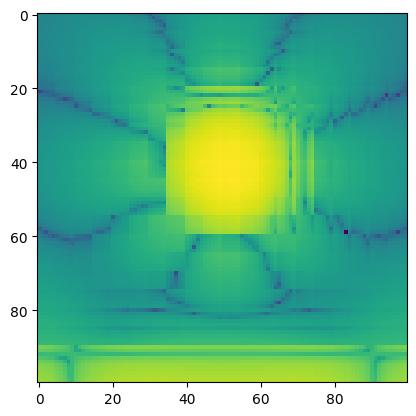

In [87]:
plt.imshow(np.rot90(abs(slab_current[:,30,:,1])), norm=LogNorm())

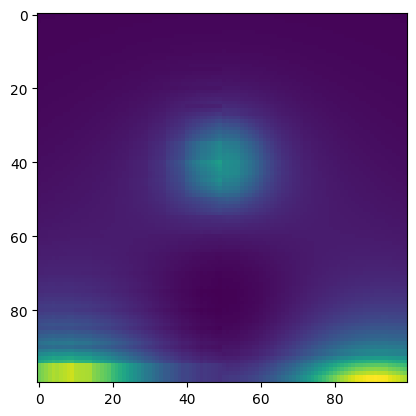

In [86]:
plt.imshow(np.rot90(slab_all[:,50,:,0])) # rho

In [14]:
from simesh.frontends.amrvac.io import load_from_uarrays
from simesh import amr_loader
import numpy as np

nw_arrays = np.ones((120, 60, 60, 8)) * 10

ds = load_from_uarrays(nw_arrays, ['rho', 'v1', 'v2', 'v3', 'e', 'b1', 'b2', 'b3'], [-2.,-1.,0.], [2.,1.,2.], [20,20,20], 'data/uni0000.dat')
ds.write_datfile('data/uni0000.dat')

Write the dataset to the file successfully:  data/uni0000.dat
